In [1]:
#seaborn 설치, 데이터 시각화, 데이터 조작, 클러스터링, 전처리를 위한 라이브러리 import
%pip install seaborn            
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

Note: you may need to restart the kernel to use updated packages.


In [2]:
#csv데이터 읽어오기
df = pd.read_csv("./보건복지부_시군구별 치매현황_20221231.csv")

In [3]:
#데이터 조작을 위한 내용 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20412 entries, 0 to 20411
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   시점            20412 non-null  int64  
 1   행정구역(시도)별     20412 non-null  object 
 2   행정구역(기초)별     20412 non-null  object 
 3   성별            20412 non-null  object 
 4   연령별           20412 non-null  object 
 5   노인인구수         20412 non-null  float64
 6   치매환자수         20412 non-null  float64
 7   치매환자유병률       20412 non-null  float64
 8   최경도 환자        20412 non-null  float64
 9   경도 환자         20412 non-null  float64
 10  중등도 환자        20412 non-null  float64
 11  중증 환자         20412 non-null  float64
 12  알츠하이머 환자수     13740 non-null  float64
 13  알츠하이머 환자유병률   13740 non-null  float64
 14  혈관성치매 환자수     13740 non-null  float64
 15  혈관성치매 환자유병률   13740 non-null  float64
 16  기타 환자환자수      13740 non-null  float64
 17  기타 환자유병률      13740 non-null  float64
 18  경도인지장애 환자수    20412 non-nu

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


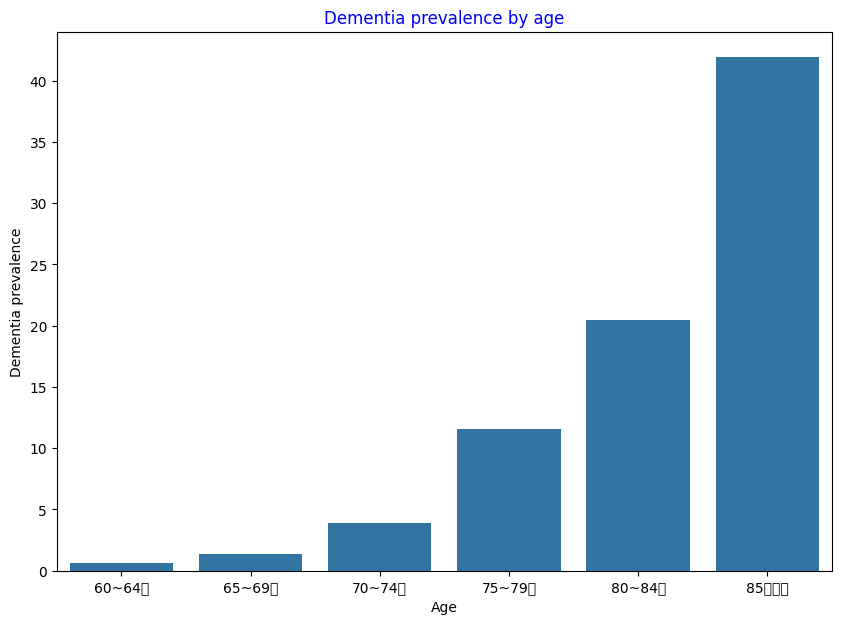

In [4]:
#겹치는 데이터 제거
df = df[df['행정구역(기초)별'] != '전국']    
df = df[df['연령별'] != '60세이상']         
df = df[df['연령별'] != '65세이상']         
#사용하지 않는 데이터 제거
df = df[df['연령별'] != '남계']            
df = df[df['연령별'] != '여계']             

top = df['치매환자유병률']
#나이와 치매간의 관계 분석
top = df.groupby('연령별')['치매환자유병률'].mean().sort_values(ascending=True) 
plt.figure(figsize=(10,7))
sns.barplot(x=top.index,y=top.values)
plt.title('Dementia prevalence by age',color = 'blue') 
plt.xlabel('Age')  #나이
plt.ylabel('Dementia prevalence') #치매 환자 유병률
plt.show()

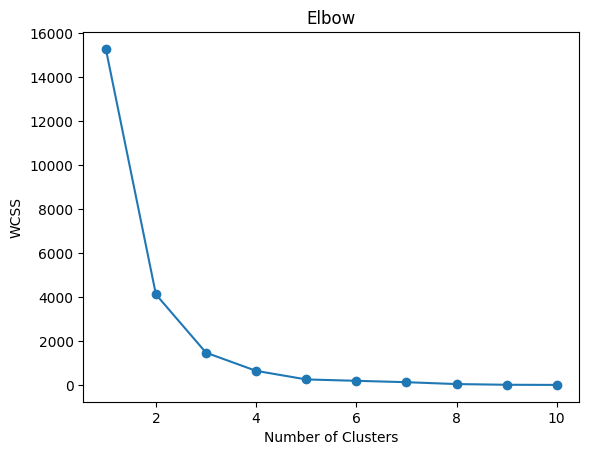

In [5]:
#치매환자유병률 열의 데이터를 표준화. StandardScaler를 사용하여 데이터의 평균을 0, 표준편차를 1로 만듬.
distinct = df[['치매환자유병률']]
scaler = StandardScaler()
distinct_scale = scaler.fit_transform(distinct)

k = range(1,11) 
wcss =[]

for i in k:  #최적의 클러스터 수(k)를 결정하기 위해 여러 k 값에 대해 클러스터링을 수행.
    kmeans = KMeans(n_clusters = i,random_state=42)
    kmeans.fit(distinct_scale)
    wcss.append(kmeans.inertia_) # WCSS값 계산 
    #클러스터 내의 데이터 포인트들이 클러스터 중심으로부터 얼마나 떨어져 있는지를 나타냄

#Elbow 그래프 그리기 x축 클러스터 수, y축 WCSS
plt.plot(k,wcss,marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow')
plt.show()

        Cluster
연령별            
60~64세     2547
65~69세     2547
70~74세     2547
75~79세     4245
80~84세     5094
85세이상      2549


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fig.canvas.print_figur

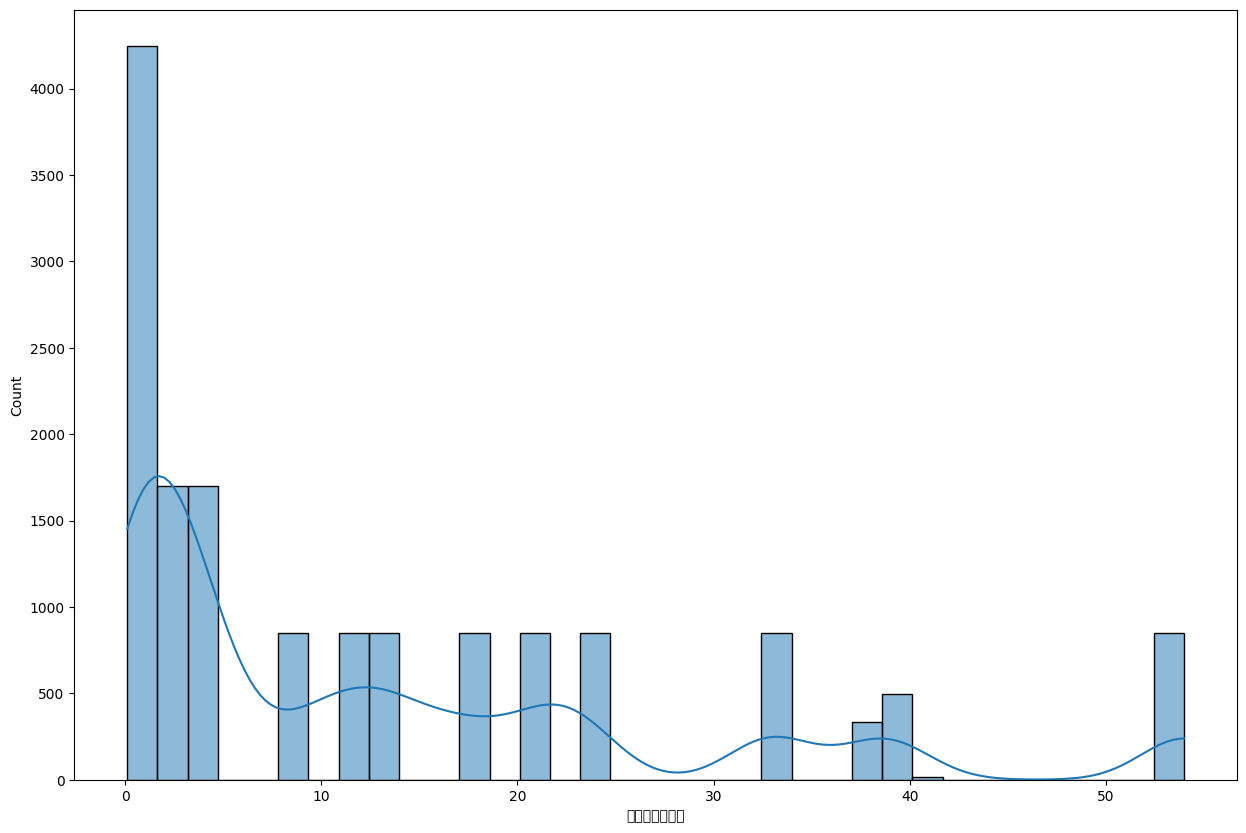

In [9]:
# 클러스터링 4개의 클러스터로 분류 
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(distinct)
#각 연령별로 클러스터 할당 후 print해서 확인
df['Cluster'] = clusters
print(df[['연령별', 'Cluster']].groupby('연령별').sum())

#데이터 histplot으로 시각화
plt.figure(figsize=(15, 10))
for i, d in enumerate(['치매환자유병률']):
    sns.histplot(df[d], kde=True)
plt.show()

     치매환자유병률
0  35.858185
1   2.698294
2  17.380177
3  53.989929


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


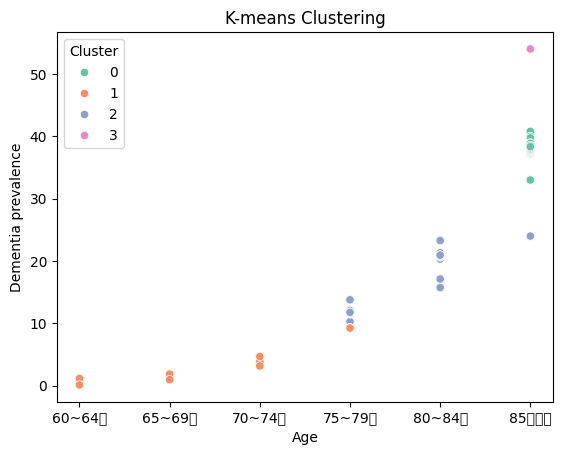

In [11]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=distinct.columns)
print(cluster_centers)

# 클러스터 시각화
df['Cluster'] = clusters
sns.scatterplot(x='연령별', y='치매환자유병률', data=df, hue='Cluster',palette='Set2')
plt.title('K-means Clustering')
plt.xlabel('Age')
plt.ylabel('Dementia prevalence')
plt.show()

In [ ]:
# 실루엣 점수 계산 후 출력
silhouette_mean = silhouette_score(distinct_scale, clusters)
print("실루엣 점수:", silhouette_mean)